# Introduction

The act of predict sales or demand is very normal at the business world, so regression techniques of machine learning is so significant to the people and enterprises.

At this notebook i'll use the CRISP-DM metodology of data mining.

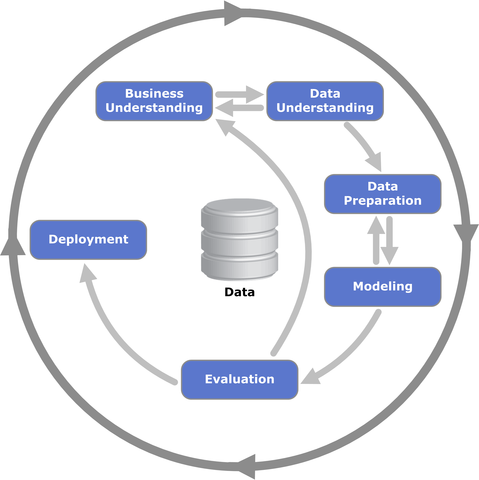

# 1. Business Understanding

Walmart is one of the largest retailers in the world, so it have to base your choses in data to have sucsess with your sells or gain more profitability.

If you know how much the stores will sales at the next months or weeks, you can better manage your stock, employees, bills and much more things.

The objective of this notebook is predict next weeks sales of walmart stores and departments, trying to minimize the WMAE error.

# 2. Data Understanding

## 2.1. Libraries

In [ ]:
# Importing basic libraries

# To work with tables and arrays
from numpy import ravel
import numpy as np
import pandas as pd

# To work with dates
import datetime

# To visualize
import seaborn as sns
import matplotlib.pyplot as plt

# To work with SQL if we need
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

# To do grid searchs
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## 2.2. Data loading

In [ ]:
features   = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/features.csv.zip')
stores     = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/stores.csv')
train      = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/train.csv.zip')
test       = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/test.csv.zip')
sample_sub = pd.read_csv('../input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip')

## 2.3. Tables overview

In [ ]:
from IPython.core.display import HTML

def multi_table(table_list):
    ''' Accepts a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table.to_html(max_rows=7) + '</td>' for table in table_list]) +
        '</tr></table>'
    )

multi_table([features,stores,train,test])

## 2.4. Merging dataframes

In [ ]:
# Merging
stores_features = pd.merge(features,stores,on='Store',how='inner')
df_main = pd.merge(stores_features,train,on=['Store','Date','IsHoliday'],how='inner')
df_main_test = pd.merge(stores_features,test,on=['Store','Date','IsHoliday'],how='inner')

# Visual check
df_main.head(3)

# 3. Data preparation

## 3.1. Data cleaning

### 3.1.1. Missing values

Here we can see that the columns wihtout documentation have many null values, so we have tree choices:
    * To fill with some techniques like the median or average of the column
    
    * To drop now
    
    * To do more tests to know if it will really improve the model

Unlike real life projects, we don't know which information these columns represents, so we cannot fill it.

We know that missing values is a problem to machine learning models, so we'll do another tests before drop these columns

In [ ]:
for col in df_main.columns:
    pct_missing = np.mean(df_main[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

### 3.1.2. Outliers

Here we can see the behavior of each column.
The boxplot presented us with the following conclusions:
    * The temperatures column have one value out of frequency bounds, but we'll don't drop it because 0ºF or 0ºC is normal in some countries.
    
    * The columns with no documentation have some values out of frequency bounds, but we'll don't drop it now, because until have the correlation test to do with these columns.
    
    * The unemployment column have some values out of frequency bounds, but we'll don't drop it because based in the global rating we know that the range of ~3-~15 is normal.
obs* To unknown exactly which information the  columns represents make the thing harder.

In [ ]:
# Taking only numerical or important columns
features = df_main[['Temperature','Fuel_Price','MarkDown1', 'MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','IsHoliday','Size','Dept']]

# Iterating and plotting
for column in features:
    plt.figure()
    sns.boxplot(data=features, x=column, width=30)

## 3.2. Construct data

Here we'll try to make four more features, check the correlations of them and turn date into a form that model can understand.

The features is:
    * The week numbers in the year
    
    * The quarter of year the week is
    
    * The holiday names
    
    * The categorical size of the store

### 3.2.1. Dates

The string type of date column is little usefull to the model, so let's turn it to integer columns and get the week number and quarter too.

In [ ]:
# Turning string type date into timestamp
df_main['Date'] = pd.to_datetime(df_main['Date'])
df_main_test['Date'] = pd.to_datetime(df_main_test['Date'])

# Creating Year, Month, Week_number and Quarter columns using date column
df_main['Year'],df_main['Month'],df_main['Week_number'],df_main['Quarter'] = df_main['Date'].dt.year, df_main['Date'].dt.month, df_main['Date'].dt.strftime("%V"), df_main['Date'].dt.quarter
df_main_test['Year'],df_main_test['Month'],df_main_test['Week_number'],df_main_test['Quarter'] = df_main_test['Date'].dt.year, df_main_test['Date'].dt.month, df_main_test['Date'].dt.strftime("%V"), df_main_test['Date'].dt.quarter

# Viewing the new columns
df_main[['Year','Month','Week_number','Quarter']]

### 3.2.2. Holidays

The holiday names and your dates can be an important feature to this model, it's not in the gave databases, so let's construct.

Obs* The names and dates of Holidays is in the competition rules.

In [ ]:
# Creating Holiday_names dict
holiday_names = {'Holiday': ['Super Bowl','Super Bowl','Super Bowl','Super Bowl','Labor Day','Labor Day','Labor Day','Labor Day','Thanksgiving','Thanksgiving','Thanksgiving','Thanksgiving','Christmas','Christmas','Christmas','Christmas']
                 ,'Date':['12-Feb-10', '11-Feb-11', '10-Feb-12', '8-Feb-13','10-Sep-10', '9-Sep-11', '7-Sep-12', '6-Sep-13','26-Nov-10', '25-Nov-11', '23-Nov-12', '29-Nov-13','31-Dec-10', '30-Dec-11', '28-Dec-12', '27-Dec-13']}

# Turning dict to pandas table and cleaning timestamp column
holiday_names = pd.DataFrame(holiday_names)
holiday_names['Date'] = pd.to_datetime(holiday_names['Date'])

# Getting the information to main dataframes
df_main = pd.merge(df_main,holiday_names,on='Date',how='left')
df_main_test = pd.merge(df_main_test,holiday_names,on='Date',how='left')

# Viewing
df_main.columns
df_main.loc[df_main['Holiday'] != None,'Holiday']

### 3.2.3. New store size column

To create new categorical features using numerical ones (binning) is a tecnic used to minimize the skew of features, making the model to generalize better.

In [ ]:
# Dividing Stores sizes in tree parts to create tree categories using it
low_max = df_main.Size.max()/3
print(low_max)

mid_max = df_main.Size.max()/3*2
print(mid_max)

high_max = df_main.Size.max()
print(high_max)

New Store_Size_cat column rules:
    
             Size            Category
            0 - 73207.3    ->  Low       
      73207.3 - 146414.6   ->  Mid       
     146414.6 - 219622     ->  High

In [ ]:
# Creating the new column using rules above
df_main['Store_Size_cat'] = pd.cut(df_main['Size'], bins=[0,df_main.Size.max()/3,df_main.Size.max()/3 * 2,df_main.Size.max()], labels=["Low", "Mid", "High"]).astype(str)
df_main_test['Store_Size_cat'] = pd.cut(df_main_test['Size'], bins=[0,df_main_test.Size.max()/3,df_main_test.Size.max()/3 * 2,df_main_test.Size.max()], labels=["Low", "Mid", "High"]).astype(str)

# Viewing
df_main['Store_Size_cat']

## 3.3. Testing Correlation

In [ ]:
# Filling null values only to test correlation 
df_main = df_main.fillna(-999)
df_main_test = df_main_test.fillna(-999)

# Getting dummies for categorical features
df_main = pd.get_dummies(df_main, columns=['Type','Holiday','Store_Size_cat'])
df_main_test = pd.get_dummies(df_main_test, columns=['Type','Holiday','Store_Size_cat'])
df_main['IsHoliday'] = df_main['IsHoliday'].astype(int)
df_main_test['IsHoliday'] = df_main_test['IsHoliday'].astype(int)

# Applying Pearson correlation matrix
corrMatrix = df_main.corr() * 100
corrMatrix = corrMatrix.round(0)

# Showing like a heatmap
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 17))
    ax = sns.heatmap(corrMatrix,mask=mask,annot=True,cmap="coolwarm", square=True, linewidths=.5, vmin=-100, vmax=100)

Correlation test Conclusions:
    * We finnally can drop 'MarkDown' columns, beacause it have many missing values, an assimetric distribution, and very low correlation to the target (WeeklySales)
    
    * The store size, dept and month have some correlation to the target, so was a good idea to create 'quarter' and 'store_size_cat' columns

In [ ]:
df_main.drop(columns=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], inplace=True)
df_main_test.drop(columns=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], inplace=True)

# Showing
df_main.head()

## 3.4. Dataset scaling

After we'll test Linear Regression, so we have the scaled form of dataset too.

In [ ]:
# Getting X and y
X_train = df_main.drop(columns=['Weekly_Sales','Date'])
X_test  = df_main.drop(columns=['Weekly_Sales','Date'])
y_train = df_main.Weekly_Sales.to_numpy().reshape(-1,1)

# X_test with date to use on model deploy
X_test_with_date  = df_main.drop(columns=['Weekly_Sales'])

# Changing columns to integer
X_train.IsHoliday   = X_train.IsHoliday.astype(int)
X_test.IsHoliday    = X_train.IsHoliday.astype(int)
X_train.Week_number = X_train.Week_number.astype(int)
X_test.Week_number = X_train.Week_number.astype(int)

# Scaling method import
from sklearn.preprocessing import StandardScaler

# Scaling features
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)

# Scaling targets
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)

# 4. Modeling/Evaluation

## 4.1. Evaluation metric

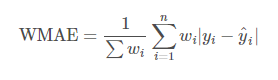

In the cell below have the evaluation metric function based on the competition rules.

In [ ]:
holiday_week = df_main.IsHoliday.apply(lambda x: True if x else False)

# Function that calculate the error
def wmae(targ,y_pred):
    sumOfWeights = 0
    sumofCol_B_X_Col_E = 0
    
    for i in range(0, len(y_pred)):
        weight = 0
        if holiday_week[i]: 
            weight = 5
        else:
            weight = 1
        
        Col_B_X_Col_E = abs(targ[i] - y_pred[i])*weight
        sumOfWeights += weight 
        sumofCol_B_X_Col_E += Col_B_X_Col_E
    WMAE = sumofCol_B_X_Col_E/sumOfWeights
    return WMAE

The make_scorer() function is used to set my own WMAE error as the main metric to chose the best parameters of the GridSearchCV().

In [ ]:
from sklearn.metrics import make_scorer
WMAE_error = make_scorer(wmae, greater_is_better=False)

## 4.2. Testing regression algorithms

Now we'll test 3 types of regressors:
    * Linear regression
    * XGBoost regressoion
    * Decision tree regression

The GridSearchCV is a really good method to fit and choose the best parameters to our model, but at the kaggle notebook we have small processing resources and when we use own scoring error method it takes more processing than normal, so we'll test a small number of tunning parameters, at the real life we can run the fit() for a several hours (at the night) or use more precessing power to do this faster.

Obs* In a kaggle notebook we can run a fit() until 9 hours long.

**Linear regression**

In [ ]:
# Linear regression library
from sklearn.linear_model import LinearRegression
li_reg = LinearRegression()

# Parameters to Grid search
tuned_parameters = [{'normalize':[True,False]}]

# Grid search
li_gs = GridSearchCV(estimator=li_reg, param_grid=tuned_parameters, scoring=WMAE_error, cv=5, n_jobs=-1)
li_gs.fit(X_train_scaled,y_train_scaled)
print('The best parameters for Linear Regression is: ',li_gs.best_params_)

**XGBoost regression**

In [ ]:
# XGBoost regressor library
import xgboost as xgb
xgb_reg = xgb.XGBRegressor(n_estimators=150)

# Parameters to Grid search
tuned_parameters = [{'learning_rate':[0.1],'max_depth':[3,4,5,10]}]

# Grid search
from sklearn.model_selection import GridSearchCV
xgb_gs = GridSearchCV(estimator=xgb_reg, param_grid=tuned_parameters, scoring=WMAE_error, cv=5, n_jobs=10)
xgb_gs.fit(X_train,y_train)
print('The best parameters for XGBoost Regression is: ',xgb_gs.best_params_)

**Decision tree regression**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=0)

# Parameters to Grid search
tuned_parameters = [{'max_depth':[2,3,4,5,10]}]

# Grid search
dt_gs = GridSearchCV(estimator=dt_reg, param_grid=tuned_parameters, scoring=WMAE_error, cv=5, n_jobs=-1)
dt_gs.fit(X_train,y_train)
print('The best parameters for SVRegression is: ',dt_gs.best_params_)

## 4.3. Evaluating

In [ ]:
print ('linear Regression: ',       wmae(y_train,li_gs.predict(X_train_scaled)).round(5))
print ('XGBoost Regression: ',      wmae(y_train,xgb_gs.predict(X_train)).round(5))
print ('Decision Tree Regression: ',wmae(y_train,dt_gs.predict(X_train)).round(5))

As we can see, the best model for this case is XGBoost

Let's take a look using a graph:

In [ ]:
fig, axs = plt.subplots(2, 2,figsize=(8,8))

axs[0, 0].scatter(xgb_gs.predict(X_train), y_train,)
axs[0, 0].set_title('XGBoost Regression')

axs[0, 1].scatter(li_gs.predict(X_train_scaled), y_train,)
axs[0, 1].set_title('Linear Regression')

axs[1, 0].scatter(dt_gs.predict(X_train), y_train,)
axs[1, 0].set_title('Decision Tree Regression')


for ax in axs.flat:
    ax.set(xlabel='Predicted', ylabel='Real')
    

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Looking at the plots of predicted vs actual prices, you can also see that the data points in XGBoost are closer to each other and farther apart in Decision tree and Linear Regression.

Obs* Linear regression is a horrible choosing to thi case, so it make visible the necessity of testing more than one machine learning algorithyms at all models.

## 4.3 Applying the model

At final, we can predict the test!

In [ ]:
y_test = xgb_gs.predict(X_test)

In [ ]:
# Menaging final_df to have competition rules standard
final_df = X_test_with_date[['Store','Dept','Date']]
final_df['Id'] = final_df['Store'].astype(str) + '-' + final_df['Dept'].astype(str) + '-' + final_df['Date'].astype(str)
final_df.drop(columns=['Store','Dept','Date'],inplace=True)
final_df['Weekly_Sales'] = y_test

final_df.head(10)

Thanks a lot!